In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'
### DAVID : this is the path to my code and data folders, probably add yours

In [7]:
net = 'highd_inputs'
### DAVID : this directs to a folder within the code from github
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model
import tools
from tools_lnd import get_model_params, name_best_ckpt, plot_FP, plot_N, make_h_and_Jac, make_Jac, gen_trials_from_model_dir, gen_X_from_model_dir_epoch

In [3]:
fldr = os.path.join('compare_effective_inputs_across_inD/')
if not os.path.exists(fldr):
    os.makedirs(fldr)

In [4]:
rule_set = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_set_names = ['DelayGo', 'ReactGo', 'MemoryGo', 'DelayAnti', 'ReactAnti', 'MemoryAnti',
              'Decison1', 'Decison2', 'ContextDecison1', 'ContextDecison2', 'MultiDecison',
              'DelayDecison1', 'DelayDecison2', 'ContextDelayDecison1', 'ContextDelayDecison2', 'MultiDelayDecison',
              'DelayMatch2SampleGo', 'DelayMatch2SampleNogo', 'DelayMatch2CategoryGo', 'DelayMatch2CategoryNoGo']

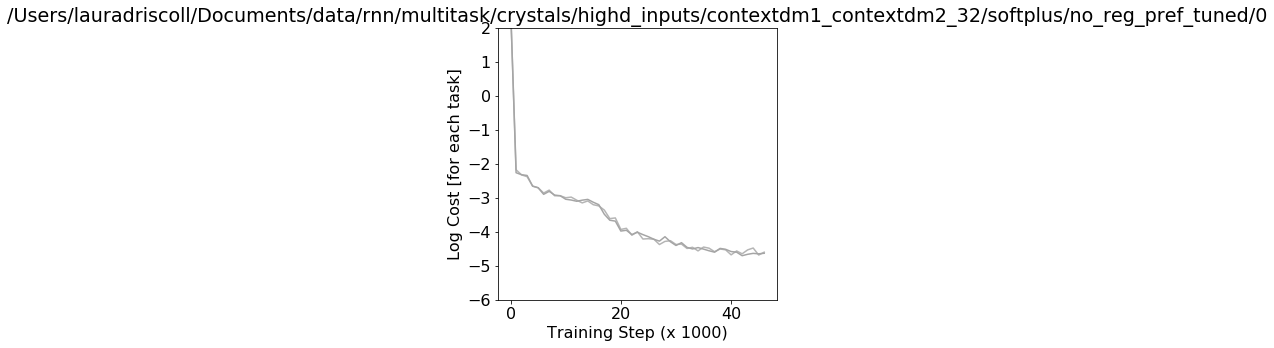

In [29]:
#This plot just shows progress over training to convince that the network looks sufficiently trained
dir_set = ['no_reg_pref_tuned','l2h00001','l2w0001','l2w00001'] 
dir_specific = dir_set[0]
model_n = 0
# model_dir_all = os.path.join(p,'data/networks_for_david/',dir_specific,str(model_n))
# task_set = np.concatenate((range(6),range(11,20)))
model_dir_all = os.path.join(p,'data/rnn/multitask/crystals/highd_inputs/contextdm1_contextdm2_32/softplus/',dir_specific,str(model_n))
task_set = [8,9] # these are the tasks i actually train on

fig = plt.figure(figsize=(5, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(model_dir_all, 'log.json')

with open(fname, 'r') as f:
    log_all = json.load(f)
for r in task_set:
    c = cmap(r/20)
    ax = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+rules_dict['all'][r]])
    plt.plot(x,'-',c = c)
    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Log Cost [for each task]')
    plt.ylim([-6,2])
    
plt.title(model_dir_all)
plt.show()    

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(341, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 33) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(33,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/contextdm1_contextdm2_32/softplus/no_reg_pref_tuned/0/ckpts/model.ckpt-42000


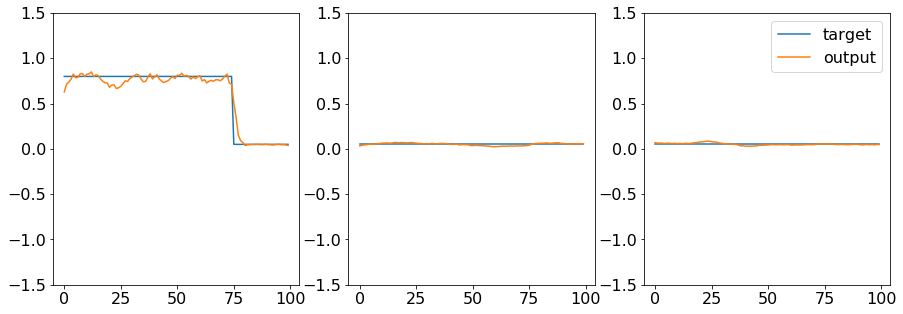

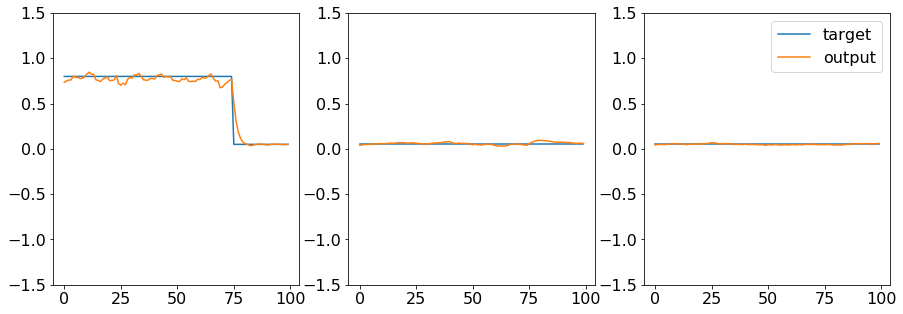

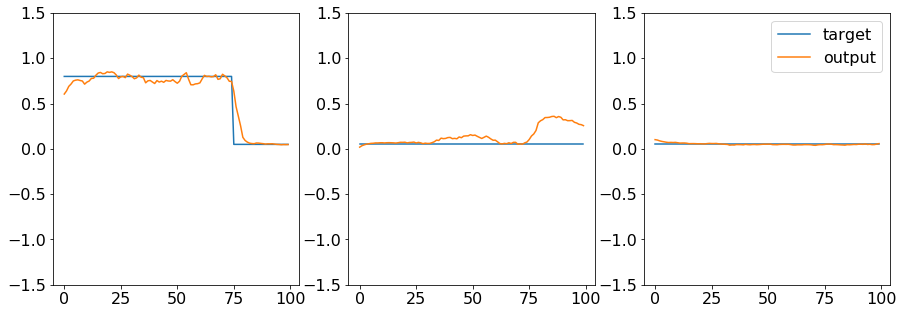

In [30]:
#These plots show some targets and outputs, again to show that the network looks sufficiently trained

rule = 'contextdm2'#'delaygo'#
ckpt_n = name_best_ckpt(model_dir_all,rule)
ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))

model = Model(model_dir_all)
with tf.Session() as sess:
    model.saver.restore(sess,ckpt_n_dir)
    model._sigma=0
    var_list = model.var_list
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='test', noise_on=True, batch_size =100, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) 
    
for y in range(3): # look at outputs compared to targets on 10 trials
    fig = plt.figure(figsize=(15, 5))
    for x in range(1,4): #three outputs
        ax = fig.add_subplot(1,3,x)
        plt.plot(trial.y[:,y,x-1],label = 'target')
        plt.plot(y_hat_tf[:,y,x-1],label = 'output')
        plt.ylim([-1.5,1.5])
        
    plt.legend()
    plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(341, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 33) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(33,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/contextdm1_contextdm2_32/softplus/no_reg_pref_tuned/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/contextdm1_contextdm2_32/softplus/no_reg_pref_tuned/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(341, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 33) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(33,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from 

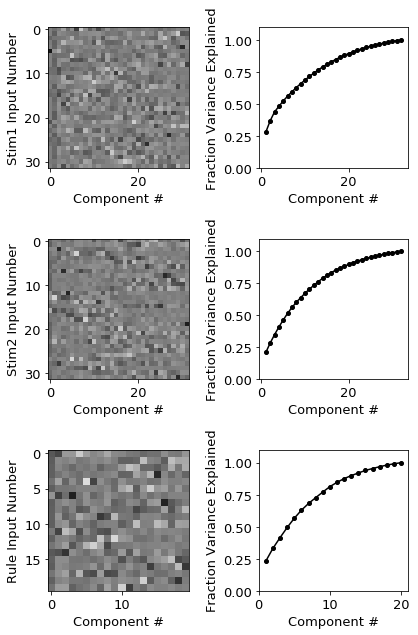

In [31]:
w_in, b_in, w_out, b_out = get_model_params(model_dir_all)
model = Model(model_dir_all)
with tf.Session() as sess:
    model.saver.restore(sess,ckpt_n_dir)
    model._sigma=0
    var_list = model.var_list
    hparams = model.hp

ni = hparams['n_eachring']

pca_stim1 = PCA()
pca_stim1.fit(w_in[:,1:ni+1])

pca_stim2 = PCA()
pca_stim2.fit(w_in[:,(ni+1):(2*ni+1)])

pca_rule = PCA()
pca_rule.fit(w_in[:,(2*ni+1):(2*ni+21)])

FONT_WEIGHT = 'bold'
fig = plt.figure(figsize=(6, 9),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 13})

ax = fig.add_subplot(3,2,1)
plt.imshow(pca_stim1.components_.T,vmin=-1, vmax=1)
ax.set_ylabel('Stim1 Input Number')
ax.set_xlabel('Component #')
ax = fig.add_subplot(3,2,2)
plt.plot(range(1,ni+1),np.cumsum(pca_stim1.explained_variance_)/np.sum(pca_stim1.explained_variance_),'-ok', markersize = 4)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Component #')
ax.set_ylabel('Fraction Variance Explained')
plt.gray()

ax = fig.add_subplot(3,2,3)
plt.imshow(pca_stim2.components_.T,vmin=-1, vmax=1)
ax.set_ylabel('Stim2 Input Number')
ax.set_xlabel('Component #')
ax = fig.add_subplot(3,2,4)
plt.plot(range(1,ni+1),np.cumsum(pca_stim2.explained_variance_)/np.sum(pca_stim2.explained_variance_),'-ok', markersize = 4)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Component #')
ax.set_ylabel('Fraction Variance Explained')
plt.gray()

ax = fig.add_subplot(3,2,5)
plt.imshow(pca_rule.components_.T,vmin=-1, vmax=1)
ax.set_ylabel('Rule Input Number')
ax.set_xlabel('Component #')
ax = fig.add_subplot(3,2,6)
plt.plot(range(1,21),np.cumsum(pca_rule.explained_variance_)/np.sum(pca_rule.explained_variance_),'-ok', markersize = 4)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Component #')
ax.set_ylabel('Fraction Variance Explained')
plt.gray()
plt.show()

In [22]:
np.shape(x1)

(256, 4, 25)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(293, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 9) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(9,) dtype=float32_ref>
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(293, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 9) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(9,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/contextdm1_contextdm2_8/softplus/no_reg_pref_tuned/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/contextdm1_contextdm2_8/softplus/no_reg_pref_tuned/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/lea

<Figure size 360x360 with 0 Axes>

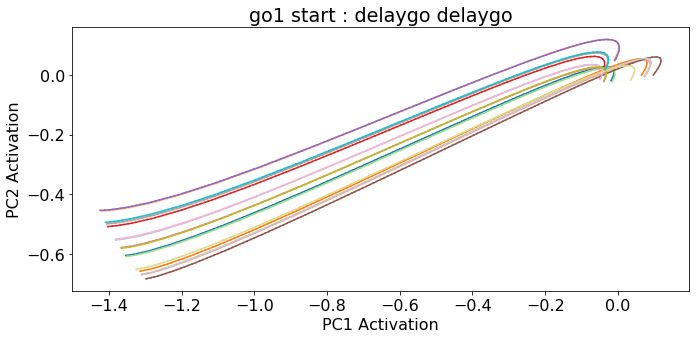

In [28]:
rule_list = ['delaygo', 'delaygo']

fig = plt.figure(figsize=(5, 5),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})
file_name = 'pca on go period'
epoch = 'go1'

for rule1_ind in range(len(rule_list)):
    for rule2_ind in range(rule1_ind+1,len(rule_list)):
        rule1 = rule_list[rule1_ind]
        rule2 = rule_list[rule2_ind]

        #MULTI
        model = Model(model_dir_all)

        trial1 = gen_trials_from_model_dir(model_dir_all,rule1)
        X1,x1 = gen_X_from_model_dir_epoch(model_dir_all,ckpt_n_dir,trial1,epoch)

        trial2 = gen_trials_from_model_dir(model_dir_all,rule2)
        X2,x2 = gen_X_from_model_dir_epoch(model_dir_all,ckpt_n_dir,trial2,epoch)

        X = np.concatenate((x1[:,:,-1], x2[:,:,-1]), axis = 1)
        pca = PCA()
        X_pca = pca.fit_transform(X.T)
        X = np.concatenate((X1, X2), axis = 1)
        X_pca = pca.transform(X.T)
        S = np.shape(x1)[1]

        n_pcs = 5
        cmap=plt.get_cmap('tab20')
        fig = plt.figure(figsize=(10, 5),tight_layout=True,facecolor='white')
        pc1 = 0
        pc2 = 1
        for t in range(S):
            c = cmap(t/S)
            trials = range(t*25,(t+1)*25)
            anti_trials = range(np.shape(X1)[1]+t*25,np.shape(X1)[1]+(t+1)*25)
            plt.plot(X_pca[trials,pc1],X_pca[trials,pc2],'-',c = c)
            plt.plot(X_pca[anti_trials,pc1],X_pca[anti_trials,pc2],':',c = c)
            plt.title(epoch+' start : ' +rule1+' '+rule2)
            plt.xlabel('PC1 Activation')
            plt.ylabel('PC2 Activation')

        plt.show()


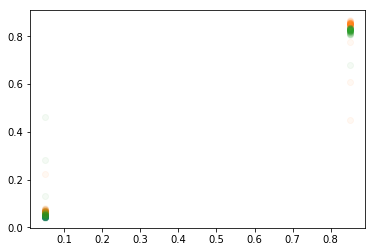

In [15]:
for x in range(np.shape(y_hat_tf)[2]):
    plt.plot(trial.y[-1,:,x],y_hat_tf[-1,:,x],'o',alpha = .05)
plt.show()

In [16]:
np.shape(trial.x)

(77, 100, 25)

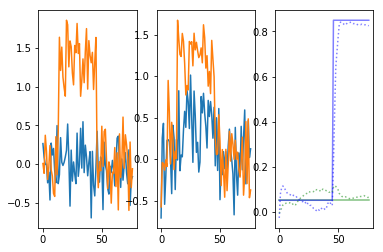

In [17]:
for x in range(1):
    plt.subplot(1,3,1)
    plt.plot(trial.x[:,x,1])
    plt.plot(trial.x[:,x,2])
    
    plt.subplot(1,3,2)
    plt.plot(trial.x[:,x,3])
    plt.plot(trial.x[:,x,4])
    
    plt.subplot(1,3,3)
    plt.plot(trial.y[:,x,1],'-g',alpha = .5)
    plt.plot(trial.y[:,x,2],'-b',alpha = .5)
    plt.plot(y_hat_tf[:,x,1],':g',alpha = .5)
    plt.plot(y_hat_tf[:,x,2],':b',alpha = .5)
    plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/contextdm1_contextdm2_2/softplus/no_reg_pref_tuned/0/ckpts/model.ckpt-41000


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


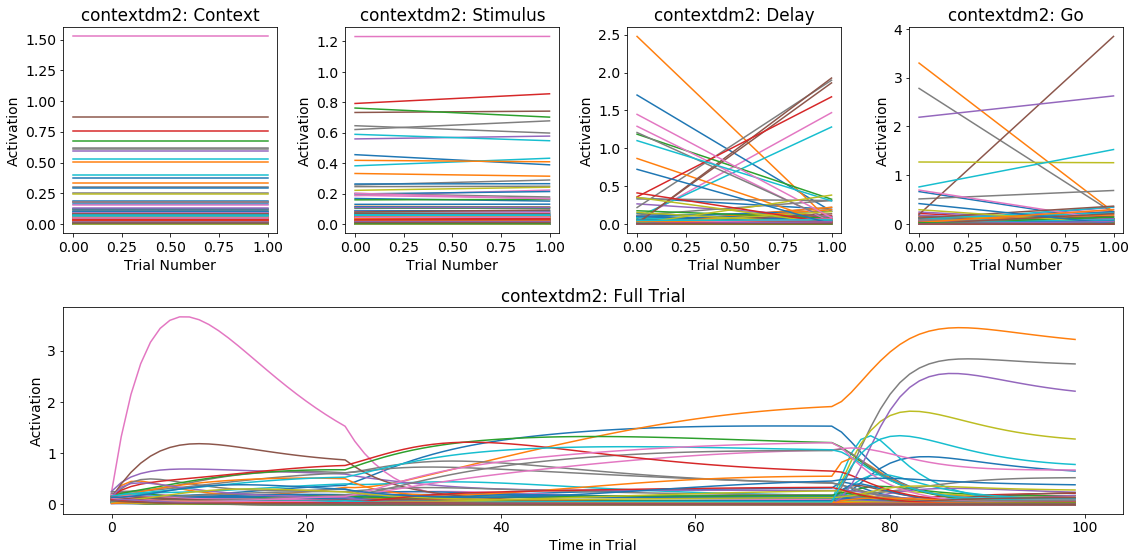

In [18]:
# Maybe useful [super basic] hidden unit activity visualization?
model_n = 0
model = Model(model_dir_all)
with tf.Session() as sess:

    ckpt_n = name_best_ckpt(model_dir_all,rule)
    ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))
    model.saver.restore(sess,ckpt_n_dir)
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='test', batch_size = 100, noise_on=False, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        
fig = plt.figure(figsize=(16, 8),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 14})

stim_ind = trial.epochs['stim1'][0]
go_ind = trial.epochs['go1'][0]
skip_trials = 16

ax1 = plt.subplot(2,4,1)
plt.plot(h_tf[stim_ind-1,0:-1:skip_trials,:]) # Every other trial to exclude modality 2
plt.title(rule + ': Context')
plt.xlabel('Trial Number')
plt.ylabel('Activation')

ax1 = plt.subplot(2,4,2)
plt.plot(h_tf[stim_ind,0:-1:skip_trials,:])
plt.title(rule + ': Stimulus')
plt.xlabel('Trial Number')
plt.ylabel('Activation')

ax1 = plt.subplot(2,4,3)
plt.plot(h_tf[go_ind-1,0:-1:skip_trials,:])
plt.title(rule + ': Delay')
plt.xlabel('Trial Number')
plt.ylabel('Activation')

ax1 = plt.subplot(2,4,4)
plt.plot(h_tf[-1,0:-1:skip_trials,:])
plt.title(rule + ': Go')
plt.xlabel('Trial Number')
plt.ylabel('Activation')

ax1 = plt.subplot(2,1,2)
plt.plot(h_tf[:,1,:])
plt.title(rule + ': Full Trial')
plt.xlabel('Time in Trial')
plt.ylabel('Activation')

plt.savefig(fldr+'simple_trial_example.svg')
plt.show()

In [70]:
model_n

3

In [71]:
# Ok jumping into the meat of it- This code generates a list of hidden state activity 
# and input Jacobians for the different tasks.
rule = 'delaygo'
time_set = trial.epochs['stim1'][0]
n_tasks = len(task_set)
eff_in_all = {}
eff_in_diff = {}
ner_set = [2,3,4,5,8,12]
x_corr_all = {}
ab_xstim = {}
ab_xotherstim = {}
xcorr_xstim = {}
model_n = 0

fig = plt.figure(figsize=(16, 4),tight_layout=True,facecolor='white')

for ner_ind in range(len(ner_set)):
    ner = ner_set[ner_ind]

    model_dir_all = os.path.join(p,'data/rnn/multitask/crystals/highd_inputs','contextdm1_contextdm2_'+str(ner),'softplus',dir_specific,str(model_n))
    trial = gen_trials_from_model_dir(model_dir_all,rule)
    ckpt_n = name_best_ckpt(model_dir_all,'contextdm1')
    d = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))
    X,x = gen_X_from_model_dir_epoch(model_dir_all,d,trial,'stim1')
    
    xtp = np.transpose(x,(1,0,2))
#     x_flat = np.reshape(xtp,(np.shape(xtp)[0],-1))
    x_flat = xtp[:,:,-1]
    
    x_corr = np.corrcoef(x_flat)
    x_corr_all[ner] = x_corr
    
    n_stim = int(np.shape(x_flat)[0]/2)
    ab_xstim[ner_ind] = np.zeros((n_stim,1))
    ab_xotherstim[ner_ind] = np.zeros((n_stim,1))
    xcorr_xstim[ner_ind] = np.zeros((n_stim,1))
    for t1 in range(n_stim):
        ab_xstim[ner_ind][t1] = distance.cosine(x_flat[2*t1,:], x_flat[2*t1+1,:])
        ab_xotherstim[ner_ind][t1] = distance.cosine(x_flat[2*t1,:], x_flat[(2*t1+2)%n_stim,:])
        xcorr_xstim[ner_ind][t1] = x_corr_all[ner][2*t1, 2*t1+1]

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/contextdm1_contextdm2_2/softplus/no_reg_pref_tuned/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/contextdm1_contextdm2_2/softplus/no_reg_pref_tuned/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users

<Figure size 1152x288 with 0 Axes>

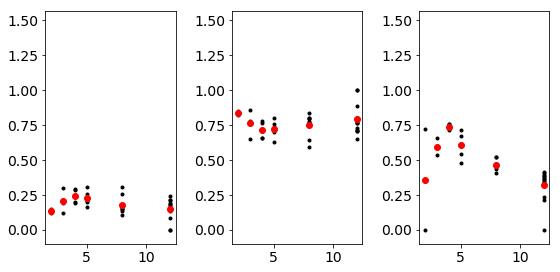

In [72]:
fig = plt.figure(figsize=(8, 4),tight_layout=True,facecolor='white')

for ner_ind in range(len(ner_set)):
    ner = ner_set[ner_ind]
    plt.subplot(1,3,1)
    plt.plot(ner*np.ones(np.shape(ab_xstim[ner_ind])),ab_xstim[ner_ind],'.k')
    plt.plot(ner,np.mean(ab_xstim[ner_ind]),'or')
    plt.ylim((-0.1,np.pi/2))
    
    plt.subplot(1,3,2)
    plt.plot(ner*np.ones(np.shape(xcorr_xstim[ner_ind])),xcorr_xstim[ner_ind],'.k')
    plt.plot(ner,np.mean(xcorr_xstim[ner_ind]),'or')
    plt.ylim((-0.1,np.pi/2))
    
    plt.subplot(1,3,3)
    plt.plot(ner*np.ones(np.shape(ab_xotherstim[ner_ind])),ab_xotherstim[ner_ind],'.k')
    plt.plot(ner,np.mean(ab_xotherstim[ner_ind]),'or')
    plt.ylim((-0.1,np.pi/2))
    
plt.show()

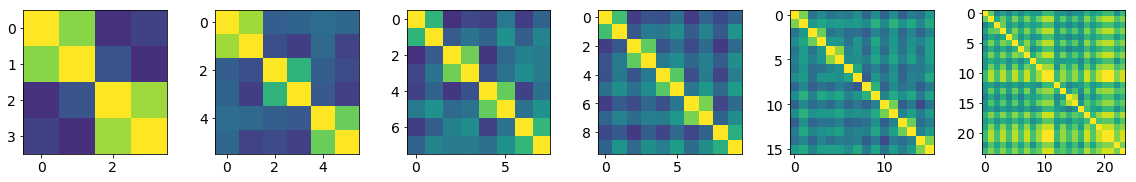

In [73]:
fig = plt.figure(figsize=(16, 12),tight_layout=True,facecolor='white')

for ner_ind in range(len(ner_set)):
    ner = ner_set[ner_ind]
    plt.subplot(1,len(ner_set),ner_ind+1)
    plt.imshow(x_corr_all[ner],vmin = 0,vmax = 1)
    
plt.show()

In [74]:
# Ok jumping into the meat of it- This code generates a list of hidden state activity 
# and input Jacobians for the different tasks.
rule = 'contextdm1'
time_set = trial.epochs['stim1'][0]
n_tasks = len(task_set)
eff_in_all = {}
eff_in_diff = {}
ab_xcontext = {}
ab_xmod = {}

for ner_ind in range(len(ner_set)):
    ner = ner_set[ner_ind]

    model_dir_all = os.path.join(p,'data/rnn/multitask/crystals/highd_inputs','contextdm1_contextdm2_'+str(ner),'softplus',dir_specific,str(model_n))
    rule = 'contextdm2'#'delaygo'#
    ckpt_n = name_best_ckpt(model_dir_all,rule)
    ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))
    
    n_total_trials = 2*ner #hparams['n_eachring']
    trial_set = range(n_total_trials)

    J_np_u_dot_delu, eff_in = make_Jac(model_dir_all,ckpt_n_dir,rule,task_set,time_set,trial_set)
    
    n_stim = int(np.shape(J_np_u_dot_delu)[1]/2)
    ab_xcontext[ner_ind] = np.zeros(2*n_stim)
    ab_xmod[ner_ind] = np.zeros(2*n_stim)
    
    for t1 in range(n_stim):
        ab_xcontext[ner_ind][t1] = distance.cosine(J_np_u_dot_delu[0,t1,:], J_np_u_dot_delu[1,t1,:])
        ab_xcontext[ner_ind][n_stim+t1] = distance.cosine(J_np_u_dot_delu[0,n_stim+t1,:], J_np_u_dot_delu[1,n_stim+t1,:])
        ab_xmod[ner_ind][t1] = distance.cosine(J_np_u_dot_delu[0,2*t1,:], J_np_u_dot_delu[0,2*t1+1,:])
        ab_xmod[ner_ind][n_stim+t1] = distance.cosine(J_np_u_dot_delu[1,2*t1,:], J_np_u_dot_delu[1,2*t1+1,:])
            
    eff_in_all[ner] = eff_in
    m1 = range(0,np.shape(eff_in)[1],2) #mod1_trials
    m2 = range(1,np.shape(eff_in)[1]+1,2) #mod2_trials
    #difference between inputs from relevant input-irrelevant input
    eff_in_diff[ner] = np.concatenate((eff_in[0,m1] - eff_in[1,m1], eff_in[1,m2] - eff_in[0,m2]))  

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/contextdm1_contextdm2_2/softplus/no_reg_pref_tuned/0/ckpts/model.ckpt-41000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(283, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 4) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(4,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/contextdm1_contextdm2_3/softplus/no_reg_pref_tuned/0/ckpts/model.ckpt-41000
Variable

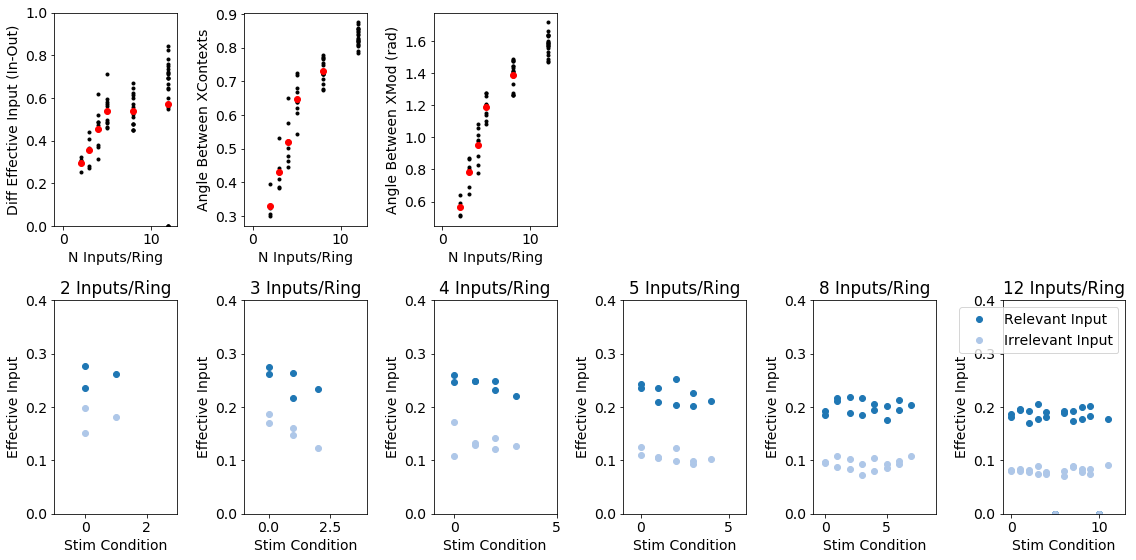

In [75]:
fig = plt.figure(figsize=(16, 8),tight_layout=True,facecolor='white')
cmap=plt.get_cmap('tab20')
# ner_set = [2,3,4,8]
counter = 0
eff_in_diff

for ner_ind in range(len(ner_set)):
    ner = ner_set[ner_ind]
    
    mean_in = np.mean(np.concatenate((eff_in_all[ner][0,0:-1:2], eff_in_all[ner][1,1:-1:2])))
    
    plt.subplot(2,len(ner_set),1)
    plt.plot(ner*np.ones(np.shape(eff_in_diff[ner])),eff_in_diff[ner]/mean_in,'.k')
    plt.plot(ner,np.mean(eff_in_diff[ner]/mean_in),'or')
    plt.ylim((0,1))
    plt.xlim((-1,ner+1))
    plt.xlabel('N Inputs/Ring')
    plt.ylabel('Diff Effective Input (In-Out)')
    
    plt.subplot(2,len(ner_set),2)
    plt.plot(ner*np.ones(np.shape(ab_xcontext[ner_ind])),ab_xcontext[ner_ind],'.k')
    plt.plot(ner,np.mean(ab_xcontext[ner_ind]),'or')
    plt.xlim((-1,ner+1))
    plt.xlabel('N Inputs/Ring')
    plt.ylabel('Angle Between XContexts')
    
    
    plt.subplot(2,len(ner_set),3)
    plt.plot(ner*np.ones(np.shape(ab_xmod[ner_ind])),ab_xmod[ner_ind],'.k')
    plt.plot(ner,np.mean(ab_xmod[ner_ind]),'or')
    plt.xlim((-1,ner+1))
    plt.xlabel('N Inputs/Ring')
    plt.ylabel('Angle Between XMod (rad)')
    
    for ta in range(2):
        for off in range(2):
            plt.subplot(2,len(ner_set),ner_ind+len(ner_set)+1)
            plt.plot(eff_in_all[ner][ta,((ta+off)%2):-1:2],'o',c = cmap(off/20))

    plt.ylim((0,.4))
    plt.xlim((-1,ner+1))
    plt.xlabel('Stim Condition')
    plt.ylabel('Effective Input')
    plt.title(str(ner) + ' Inputs/Ring')
    
plt.legend(('Relevant Input','Irrelevant Input'))

plt.show()

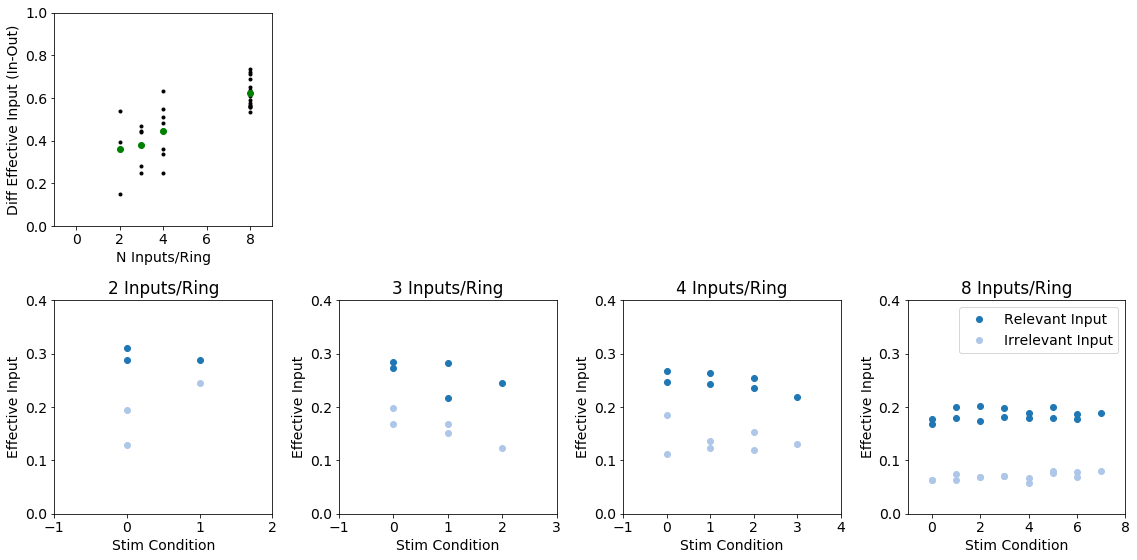

In [61]:
fig = plt.figure(figsize=(16, 8),tight_layout=True,facecolor='white')
cmap=plt.get_cmap('tab20')
ner_set = [2,3,4,8]
counter = 0
eff_in_diff

for ner_ind in range(len(ner_set)):
    ner = ner_set[ner_ind]
    
    mean_in = np.mean(np.concatenate((eff_in_all[ner][0,0:-1:2], eff_in_all[ner][1,1:-1:2])))
    
    plt.subplot(2,len(ner_set),1)
    plt.plot(ner*np.ones(np.shape(eff_in_diff[ner])),eff_in_diff[ner]/mean_in,'.k')
    plt.plot(ner,np.mean(eff_in_diff[ner]/mean_in),'og')
    
    for ta in range(2):
        for off in range(2):
            plt.subplot(2,len(ner_set),ner_ind+1+len(ner_set))
            plt.plot(eff_in_all[ner][ta,((ta+off)%2):-1:2],'o',c = cmap(off/20))
    
    plt.ylim((0,.4))
    plt.xlim((-1,ner))
    plt.xlabel('Stim Condition')
    plt.ylabel('Effective Input')
    plt.title(str(ner) + ' Inputs/Ring')
    
plt.legend(('Relevant Input','Irrelevant Input'))

plt.subplot(2,len(ner_set),1)
plt.ylim((0,1))
plt.xlim((-1,ner+1))
plt.xlabel('N Inputs/Ring')
plt.ylabel('Diff Effective Input (In-Out)')

plt.show()

In [23]:
np.shape(trial.x)

(77, 100, 85)

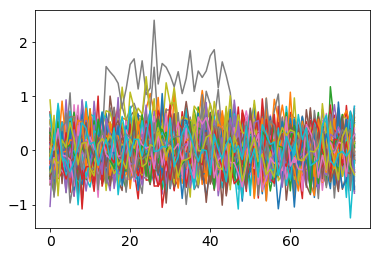

In [26]:
plt.plot(trial.x[:,:,2])
plt.show()

In [12]:
# Ok jumping into the meat of it- This code generates a list of hidden state activity 
# and input Jacobians for the different tasks.

rule = 'contextdm1'
n_tasks = len(task_set)
n_total_trials = 2*hparams['n_eachring'] # num trials in delaygo task
n_trials_use = hparams['n_eachring']
skip_trials = int(n_total_trials/n_trials_use)
#mod1 and mod2 are every other trial so we grab 8 trials from both groups spanning 360 stim angles
trial_set = np.concatenate((range(0,n_total_trials,skip_trials),range(1,n_total_trials,skip_trials)))
n_stim_dims = 2*hparams['n_eachring']+1
time_set = trial.epochs['stim1'][0]

J_np_u_dot_delu = make_Jac(model_dir_all,rule,task_set,time_set,trial_set)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(283, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 4) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(4,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/contextdm1_contextdm2_3/softplus/no_reg_pref_tuned/0/ckpts/model.ckpt-85000


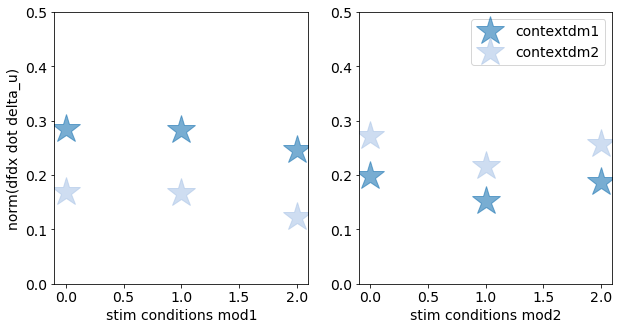

In [11]:
r_set = range(len(task_set))
cmap=plt.get_cmap('tab20')
a = .6
mSize = 30
n_stim = int(np.shape(J_np_u_dot_delu)[1]/2)

fig = plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 14})
plt.subplot(1,2,1)
for stim1 in range(n_stim):
    for r in r_set:
        c = cmap(r/20)
        if stim1 == 0:
            plt.subplot(1,2,1)
            plt.plot(stim1,LA.norm(J_np_u_dot_delu[r,stim1,:]),'*',markersize = mSize,alpha = a, c = c,label = rules_dict['all'][task_set[r]])
            plt.subplot(1,2,2)
            plt.plot(stim1,LA.norm(J_np_u_dot_delu[r,stim1+n_stim,:]),'*',markersize = mSize,alpha = a, c = c,label = rules_dict['all'][task_set[r]])
        else:
            plt.subplot(1,2,1)
            plt.plot(stim1,LA.norm(J_np_u_dot_delu[r,stim1,:]),'*',markersize = mSize,alpha = a, c = c)
            plt.subplot(1,2,2)
            plt.plot(stim1,LA.norm(J_np_u_dot_delu[r,stim1+n_stim,:]),'*',markersize = mSize,alpha = a, c = c)

plt.subplot(1,2,1)
plt.xlabel('stim conditions mod1')
plt.ylabel('norm(dfdx dot delta_u)')
plt.ylim((0,.5))

plt.subplot(1,2,2)
plt.xlabel('stim conditions mod2')
plt.ylim((0,.5))

plt.legend()
plt.show()

In [18]:
model = Model(model_dir_all)
with tf.Session() as sess:

    ckpt_n = name_best_ckpt(model_dir_all,rule)
    ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))
    model.saver.restore(sess,ckpt_n_dir)
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    trial_delaygo = generate_trials('delaygo', hparams, mode='test', noise_on=False, delay_fac =1)
    trial_contextdm1 = generate_trials('contextdm1', hparams, mode='test', noise_on=False, delay_fac =1)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/contextdm1_contextdm2_4/softplus/no_reg_pref_tuned/0/ckpts/model.ckpt-41000


In [19]:
np.shape(trial_delaygo.x)

(125, 400, 29)

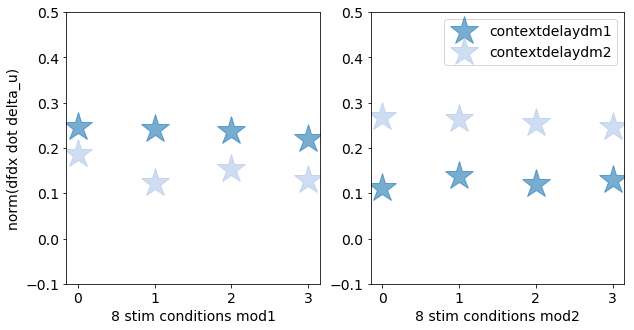

In [140]:
r_set = range(2)
cmap=plt.get_cmap('tab20')

fig = plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 14})
plt.subplot(1,2,1)
for stim1 in range(hparams['n_eachring']):
    for r in r_set:
        c = cmap(r/20)
        if stim1 == 0:
            plt.subplot(1,2,1)
            plt.plot(stim1,LA.norm(J_np_u_dot_delu[r,stim1,:,:]),'*',markersize = mSize,alpha = a, c = c,label = rule_set[task_set[r]])
            plt.subplot(1,2,2)
            plt.plot(stim1,LA.norm(J_np_u_dot_delu[r,stim1+hparams['n_eachring'],:,:]),'*',markersize = mSize,alpha = a, c = c,label = rule_set[task_set[r]])
        else:
            plt.subplot(1,2,1)
            plt.plot(stim1,LA.norm(J_np_u_dot_delu[r,stim1,:,:]),'*',markersize = mSize,alpha = a, c = c)
            plt.subplot(1,2,2)
            plt.plot(stim1,LA.norm(J_np_u_dot_delu[r,stim1+hparams['n_eachring'],:,:]),'*',markersize = mSize,alpha = a, c = c)

plt.subplot(1,2,1)
plt.xlabel('8 stim conditions mod1')
plt.ylabel('norm(dfdx dot delta_u)')
plt.ylim((-.1,.5))

plt.subplot(1,2,2)
plt.xlabel('8 stim conditions mod2')
plt.ylim((-.1,.5))

plt.legend()
plt.show()

In [59]:
n_eachring = 8
pref = np.arange(0,2*np.pi,2*np.pi/n_eachring)
x_loc = 2*np.pi/4
dist = (x_loc - pref)/(2*np.pi/128)
activation = 0.8*np.exp(-dist**2/2)

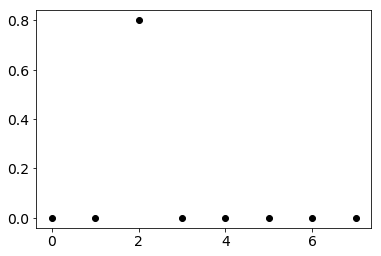

In [60]:
plt.plot(activation,'ok')
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/networks_for_david/l2w0001/0/ckpts/model.ckpt-270000


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


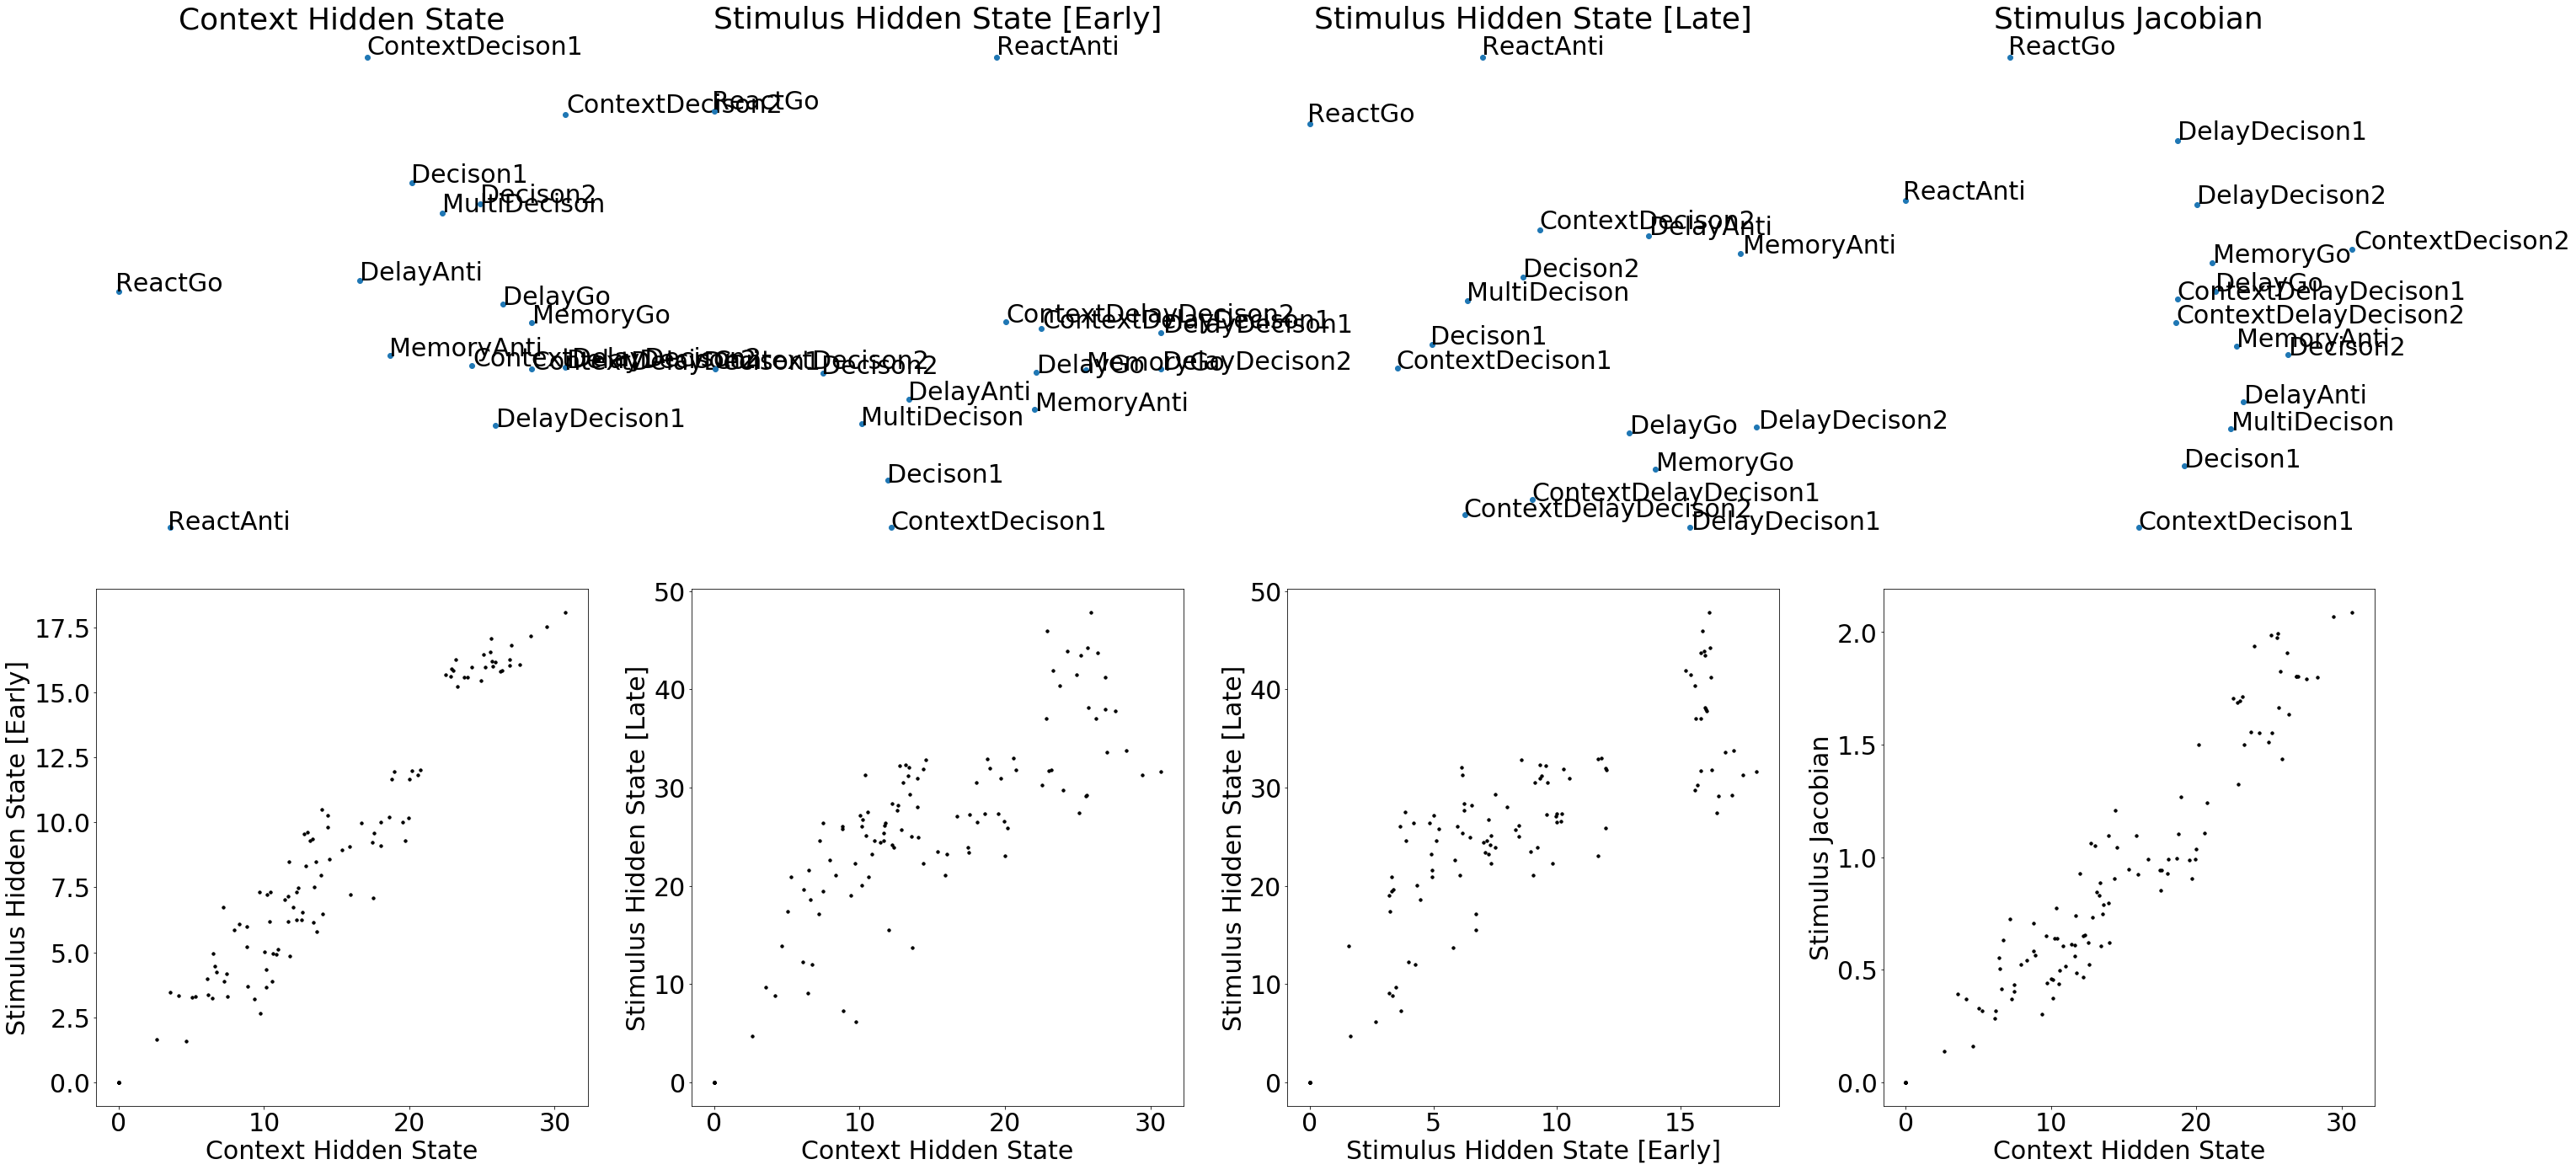

In [52]:
model_dir_all = os.path.join(p,'data/networks_for_david/',dir_specific,str(model_n))
J_np_u_dot_delu, h_context_combined, h_stim_late_combined, h_stim_early_combined = make_h_and_Jac(model_dir_all)

# Distances across different tasks
dist = DistanceMetric.get_metric('euclidean')
X_euc_context = dist.pairwise(np.squeeze(h_context_combined))
X_euc_stim_early = dist.pairwise(np.squeeze(h_stim_early_combined-h_context_combined))
X_euc_stim_late = dist.pairwise(np.squeeze(h_stim_late_combined-h_context_combined))
X_euc_stim_Jac = dist.pairwise(np.reshape(np.squeeze(J_np_u_dot_delu),(n_tasks,-1)))

# MDS for each metric
X_context = do_MDS(h_context_combined)
X_del_stim_early = do_MDS(h_stim_early_combined-h_context_combined)
X_del_stim_late = do_MDS(h_stim_late_combined-h_context_combined)
X_stim_Jac = do_MDS(np.reshape(np.squeeze(J_np_u_dot_delu),(n_tasks,-1)))

fig = plt.figure(figsize=(40, 20),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 30})

ax1 = plt.subplot(2,4,1)
plot_MDS_tasks(X_context)
plt.title('Context Hidden State')

ax2 = plt.subplot(2,4,2)
plot_MDS_tasks(X_del_stim_early)
plt.title('Stimulus Hidden State [Early]')

ax2 = plt.subplot(2,4,3)
plot_MDS_tasks(X_del_stim_late)
plt.title('Stimulus Hidden State [Late]')

ax2 = plt.subplot(2,4,4)
plot_MDS_tasks(X_stim_Jac)
plt.title('Stimulus Jacobian')

ax3 = plt.subplot(2,4,5)
plt.plot(X_euc_context[:],X_euc_stim_early[:],'.k')
plt.xlabel('Context Hidden State')
plt.ylabel('Stimulus Hidden State [Early]')

ax3 = plt.subplot(2,4,6)
plt.plot(X_euc_context[:],X_euc_stim_late[:],'.k')
plt.xlabel('Context Hidden State')
plt.ylabel('Stimulus Hidden State [Late]')

ax3 = plt.subplot(2,4,7)
plt.plot(X_euc_stim_early[:],X_euc_stim_late[:],'.k')
plt.xlabel('Stimulus Hidden State [Early]')
plt.ylabel('Stimulus Hidden State [Late]')

ax3 = plt.subplot(2,4,8)
plt.plot(X_euc_context[:],X_euc_stim_Jac[:],'.k')
plt.xlabel('Context Hidden State')
plt.ylabel('Stimulus Jacobian')

plt.show()

In [23]:
X_euc_context_all = {}
X_euc_stim_early_all = {}
X_euc_stim_late_all = {}
X_euc_stim_Jac_all = {}

model_n = 0

for d in range(len(dir_set)):
    dir_specific = dir_set[d]
    model_dir_all = os.path.join(p,'data/networks_for_david/',dir_specific,str(model_n))
    J_np_u_dot_delu, h_context_combined, h_stim_late_combined, h_stim_early_combined = make_h_and_Jac(model_dir_all)

    # Distances across different tasks
    dist = DistanceMetric.get_metric('euclidean')
    X_euc_context = dist.pairwise(np.squeeze(h_context_combined))
    X_euc_stim_early = dist.pairwise(np.squeeze(h_stim_early_combined-h_context_combined))
    X_euc_stim_late = dist.pairwise(np.squeeze(h_stim_late_combined-h_context_combined))
    X_euc_stim_Jac = dist.pairwise(np.reshape(np.squeeze(J_np_u_dot_delu),(n_tasks,-1)))

    # MDS for each metric
    X_context = do_MDS(h_context_combined)
    X_del_stim_early = do_MDS(h_stim_early_combined-h_context_combined)
    X_del_stim_late = do_MDS(h_stim_late_combined-h_context_combined)
    X_stim_Jac = do_MDS(np.reshape(np.squeeze(J_np_u_dot_delu),(n_tasks,-1)))

    X_euc_context_all[dir_specific] = X_euc_context
    X_euc_stim_early_all[dir_specific] = X_euc_stim_early
    X_euc_stim_late_all[dir_specific] = X_euc_stim_late
    X_euc_stim_Jac_all[dir_specific] = X_euc_stim_Jac

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/networks_for_david/no_reg/0/ckpts/model.ckpt-389000


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/networks_for_david/l2h00001/0/ckpts/model.ckpt-462000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/networks_for_david/l2w0001/0/ckpts/model.ckpt-270000


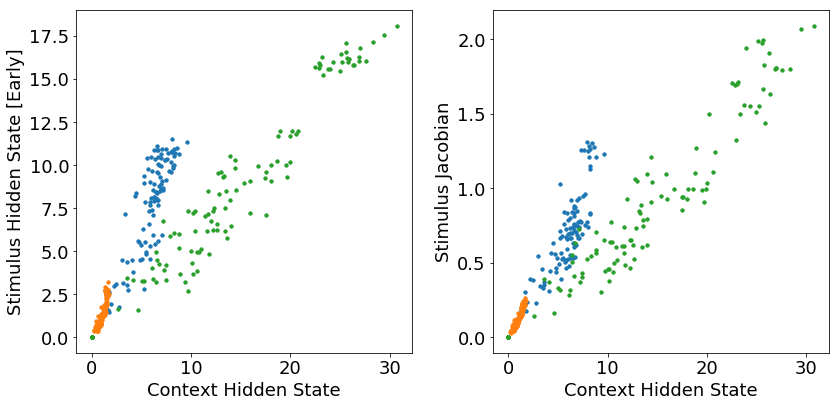

In [24]:
fig = plt.figure(figsize=(12, 6),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 18})

dir_set = ['no_reg','l2h00001','l2w0001'] 
cmap = plt.cm.get_cmap('tab10')

for ii in range(3):
    d = dir_set[ii]
    c = cmap(ii/10)
    ax3 = plt.subplot(1,2,1)
    plt.plot(X_euc_context_all[d][:],X_euc_stim_early_all[d][:],'.',c=c)
    plt.xlabel('Context Hidden State')
    plt.ylabel('Stimulus Hidden State [Early]')

    ax3 = plt.subplot(1,2,2)
    plt.plot(X_euc_context_all[d][:],X_euc_stim_Jac_all[d][:],'.',c=c)
    plt.xlabel('Context Hidden State')
    plt.ylabel('Stimulus Jacobian')

plt.show()

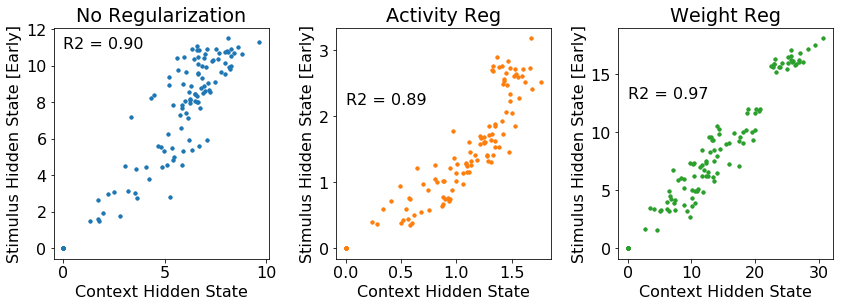

In [25]:
import scipy


fig = plt.figure(figsize=(12, 8),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})

dir_set = ['no_reg','l2h00001','l2w0001']
labels = ['No Regularization','Activity Reg','Weight Reg']
cmap = plt.cm.get_cmap('tab10')

for ii in range(3):
    d = dir_set[ii]
    c = cmap(ii/10)
    t = labels[ii]

    ax3 = plt.subplot(2,3,ii+1)
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X_euc_context_all[d].flatten(), X_euc_stim_early_all[d].flatten())
    plt.plot(X_euc_context_all[d].flatten(),X_euc_stim_early_all[d].flatten(),'.',c=c)
    plt.xlabel('Context Hidden State')
    plt.ylabel('Stimulus Hidden State [Early]')
    plt.title(t)
    s = 'R2 = '+ "{:.2f}".format(r_value)
    plt.text(0,1.5*np.mean(X_euc_stim_early_all[d].flatten()),s)

    
plt.savefig('sfn/for_David/stim_v_context_and_jac.svg')
plt.show()

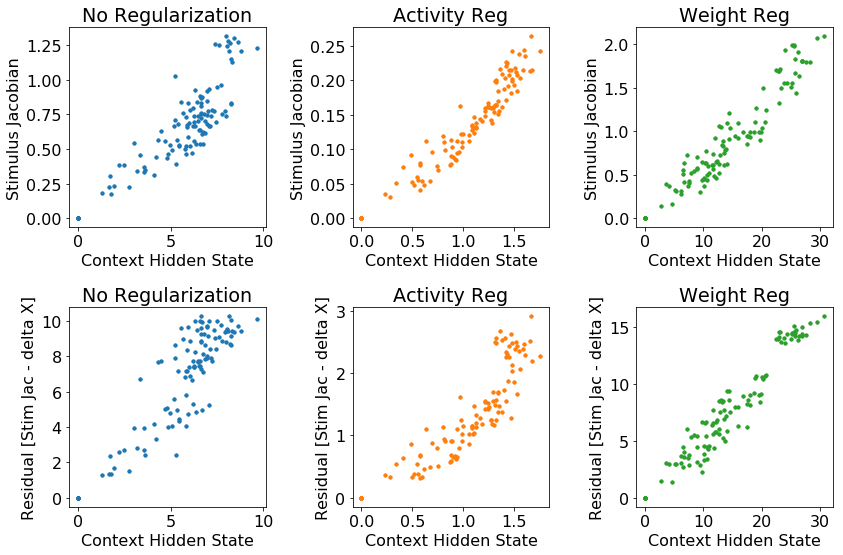

In [26]:
#Wanted to plot the difference between the stimulus jacobian and the actual update 
#but the scales are off so i don't think this analysis really makes sense.

fig = plt.figure(figsize=(12, 8),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})

dir_set = ['no_reg','l2h00001','l2w0001']
labels = ['No Regularization','Activity Reg','Weight Reg']
cmap = plt.cm.get_cmap('tab10')

for ii in range(3):
    d = dir_set[ii]
    c = cmap(ii/10)
    t = labels[ii]

    ax3 = plt.subplot(2,3,ii+1)
    plt.plot(X_euc_context_all[d][:],X_euc_stim_Jac_all[d][:],'.',c=c)
    plt.xlabel('Context Hidden State')
    plt.ylabel('Stimulus Jacobian')
    plt.title(t)

    ax3 = plt.subplot(2,3,ii+1+3)
    plt.plot(X_euc_context_all[d][:],X_euc_stim_early_all[d][:] - X_euc_stim_Jac_all[d][:],'.',c=c)
    plt.xlabel('Context Hidden State')
    plt.ylabel('Residual [Stim Jac - delta X]')
    plt.title(t)

    
plt.savefig('sfn/for_David/stim_v_context_and_residual.svg')
plt.show()

In [7]:
 ## JAX fixed point stuff
sys.path.append(os.path.join(p,'code','computation-thru-dynamics'))
import fixed_point_finder.decision as decision
import fixed_point_finder.fixed_points as fp_optimize
import fixed_point_finder.rnn as rnn
import fixed_point_finder.utils as utils

import h5py
import jax.numpy as np
from jax import jacrev, random, vmap
from jax.experimental import optimizers
from jax.ops import index, index_add, index_update
import numpy as onp             # original CPU-backed NumPy

model = Model(model_dir_all)
rule = 'delaygo'
with tf.Session() as sess:
    model.restore()
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    # create a trial
    trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size =1000, delay_fac =1)
    # get feed_dict
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    # run model
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/networks_for_david/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/networks_for_david/l2w0001/0/model.ckpt


In [8]:
if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    return np.dot(params[2].T,h)+params[3]

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x):
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def vanilla_run_with_h0(params, x_t, h0):
    h = h0
    h_t = []
    h_t.append(h)
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T))
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    o_t = batch_affine(params, h_t)
    return h_t, o_t

def generate_Beta_epoch(h_tf,trial):
    Beta_epoch1 = {}
    Beta_epoch2 = {}

    for epoch in trial.epochs.keys():
        T_use = trial.epochs[epoch][1], 
        if T_use[0] is None:
            T_use = np.shape(trial.x)
            
        inds_use = trial.stim_strength[:,0]>.99
        X = h_tf[T_use[0]-1,inds_use,:].T
        X_zscore = stats.zscore(X, axis=1)
        X_zscore_nonan = X_zscore
        X_zscore_nonan[np.isnan(X_zscore)] = 0
        r = X_zscore_nonan

        y1 = np.sin(trial.stim_locs[inds_use,0:1])
        y2 = np.cos(trial.stim_locs[inds_use,0:1])
        y = onp.concatenate((y1,y2),axis=1)

        lm = linear_model.LinearRegression()
        model = lm.fit(y,r.T)
        Beta = model.coef_
        Beta_epoch1[epoch],_ = LA.qr(Beta)

        inds_use = trial.stim_strength[:,1]>.99
        X = h_tf[T_use[0]-1,inds_use,:].T
        X_zscore = stats.zscore(X, axis=1)
        X_zscore_nonan = X_zscore
        X_zscore_nonan[np.isnan(X_zscore)] = 0
        r = X_zscore_nonan
        
        y1 = np.sin(trial.stim_locs[inds_use,1:2])
        y2 = np.cos(trial.stim_locs[inds_use,1:2])
        y = onp.concatenate((y1,y2),axis=1)

        lm = linear_model.LinearRegression()
        model = lm.fit(y,r.T)
        Beta = model.coef_
        Beta_epoch2[epoch],_ = LA.qr(Beta)

    return Beta_epoch1, Beta_epoch2

In [124]:
rule = 'delaygo'
fp_epoch = 'delay1'

model = Model(model_dir_all)
with tf.Session() as sess:
    model.restore()
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

# get trial shape
_,B,N = np.shape(h_tf)
trial_set = range(0,B,int(B/100))
trial_set = range(B)

# Fixed point epoch
T = trial.epochs[fp_epoch][1]

# Input during fixed point epoch
x_star = trial.x[T-1,0,:]  

# Make a one parameter function of thie hidden state, useful for jacobians.
rnn_fun = lambda h : rnn_vanilla(params, h, x_star)
batch_rnn_fun = vmap(rnn_fun, in_axes=(0,))

fp_candidates = np.transpose(h_tf,(1,0,2))  # was batch x time x dim
a = np.reshape(fp_candidates[range(0,10),trial.epochs['fix1'][1],:], (-1, N)) # now batch * time x dim
b = np.reshape(fp_candidates[trial_set,T-1:T,:], (-1, N)) # now batch * time x dim
fp_candidates = np.concatenate((a, b), axis=0)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/networks_for_david/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/networks_for_david/l2w0001/0/model.ckpt


In [125]:
fp_loss_fun = fp_optimize.get_fp_loss_fun(rnn_fun)
total_fp_loss_fun = fp_optimize.get_total_fp_loss_fun(rnn_fun)

# Fixed point optimization hyperparameters
fp_num_batches = 10000       # Total number of batches to train on.
fp_batch_size = 128          # How many examples in each batch
fp_step_size = 0.2           # initial learning rate
fp_decay_factor = 0.9999     # decay the learning rate this much
fp_decay_steps = 1           #
fp_adam_b1 = 0.9             # Adam parameters
fp_adam_b2 = 0.999
fp_adam_eps = 1e-5
fp_opt_print_every = 100   # Print training information during optimziation every so often

# Fixed point finding thresholds and other HPs
fp_noise_var = 0.0001      # Gaussian noise added to fixed point candidates before optimization.
fp_opt_stop_tol = 0.000001  # Stop optimizing when the average value of the batch is below this value.
fp_tol = 0.000001        # Discard fps with squared speed larger than this value.
fp_unique_tol = 0.025   # tolerance for determination of identical fixed points
fp_outlier_tol = 1.0    # Anypoint whos closest fixed point is greater than tol is an outlier.

In [126]:
reload(fp_optimize)

fp_tols = [0.000001, 0.00000005, 0.00000002] # Used for both fp_tol and opt_stop_tol

all_fps = {}
for tol in fp_tols:
    fp_hps = {'num_batches' : fp_num_batches, 
              'step_size' : fp_step_size, 
              'decay_factor' : fp_decay_factor, 
              'decay_steps' : fp_decay_steps, 
              'adam_b1' : fp_adam_b1, 'adam_b2' : fp_adam_b2, 'adam_eps' : fp_adam_eps,
              'noise_var' : fp_noise_var, 
              'fp_opt_stop_tol' : tol, 
              'fp_tol' : tol, 
              'unique_tol' : fp_unique_tol, 
              'outlier_tol' : fp_outlier_tol, 
              'opt_print_every' : fp_opt_print_every}
    fps, fp_losses, fp_idxs, fp_opt_details = \
        fp_optimize.find_fixed_points(rnn_fun, fp_candidates, fp_hps, do_print=True)
    if len(fp_idxs) > 0:
        F_of_fps = batch_rnn_fun(fps)
    else:
        F_of_fps = onp.zeros([0,N])
        
    all_fps[tol] = {'fps' : fps, 'candidates' : fp_candidates[fp_idxs],
                    'losses' : fp_losses, 'F_of_fps' : F_of_fps, 
                    'opt_details' : fp_opt_details, 'hps' : fp_hps}

    all_fps[tol]


Adding noise to fixed point candidates.
Optimizing to find fixed points.
    Batches 1-100 in 0.45 sec, Step size: 0.19801, Training loss 0.00000
Stopping as mean training loss 0.00000 is below tolerance 0.00000.
Excluding fixed points with squared speed above tolerance 0.00000.
    Kept 410/410 fixed points with tolerance under 0.000001.
Excluding non-unique fixed points.
    Kept 410/410 unique fixed points with uniqueness tolerance 0.025000.
Excluding outliers.
    Kept 410/410 fixed points with within outlier tolerance 1.000000.
Sorting fixed points slowest first.
Adding noise to fixed point candidates.
Optimizing to find fixed points.
    Batches 1-100 in 0.40 sec, Step size: 0.19801, Training loss 0.00000
Stopping as mean training loss 0.00000 is below tolerance 0.00000.
Excluding fixed points with squared speed above tolerance 0.00000.
    Kept 400/410 fixed points with tolerance under 0.000000.
Excluding non-unique fixed points.
    Kept 400/400 unique fixed points with uniquen

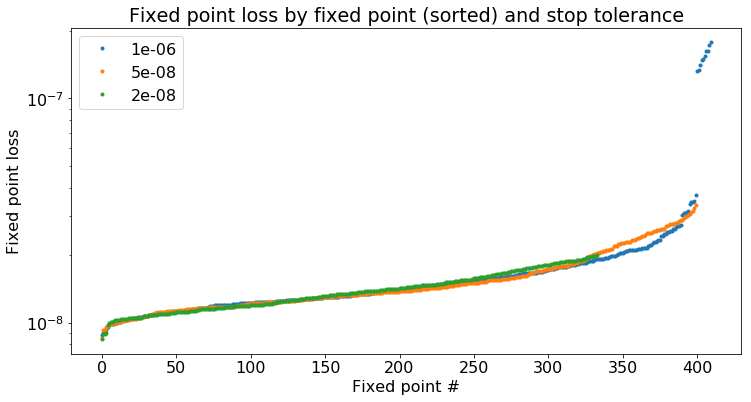

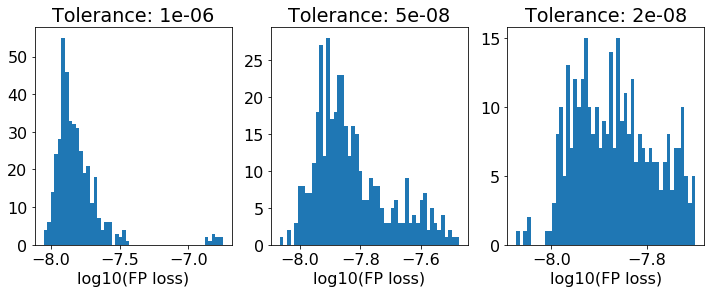

In [127]:
f1 = plt.figure(figsize=(12,6))

for tol in fp_tols: 
    plt.semilogy(all_fps[tol]['losses'],'.'); 
    plt.xlabel('Fixed point #')
    plt.ylabel('Fixed point loss');
plt.legend(fp_tols)
plt.title('Fixed point loss by fixed point (sorted) and stop tolerance')

f2 = plt.figure(figsize=(12,4))

pidx = 1
nfp_tols = len(fp_tols)
for tol_idx, tol in enumerate(fp_tols):
    plt.subplot(1, nfp_tols, pidx); pidx += 1
    plt.hist(onp.log10(fp_loss_fun(all_fps[tol]['fps'])), 50);
    plt.xlabel('log10(FP loss)')
    plt.title('Tolerance: ' + str(tol));

In [135]:
best_tol = fp_tols[2] #2 is the slowest fps

fps = all_fps[best_tol]['fps']
fp_readouts = onp.squeeze(onp.dot(params[2].T,fps.T)+onp.expand_dims(params[3], axis=1)) #readout before go will be zero

if np.shape(fps)[0]==1:
    sorted_fp_readouts = fp_readouts[1]
    sorted_fps = fps
    jacs = fp_optimize.compute_jacobians(rnn_fun, sorted_fps)
    eig_decomps = fp_optimize.compute_eigenvalue_decomposition(jacs, sort_by='real', do_compute_lefts=True)
    
else:
    fp_ro_sidxs = onp.argsort(fp_readouts[1,:])
    sorted_fp_readouts = fp_readouts[1,fp_ro_sidxs]
    sorted_fps = fps[fp_ro_sidxs]

    downsample_fps = 4 # Use this if too many fps
    sorted_fp_readouts = sorted_fp_readouts[0:-1:downsample_fps]
    sorted_fps = sorted_fps[0:-1:downsample_fps]
    jacs = fp_optimize.compute_jacobians(rnn_fun, sorted_fps)
    eig_decomps = fp_optimize.compute_eigenvalue_decomposition(jacs, sort_by='real', do_compute_lefts=True)

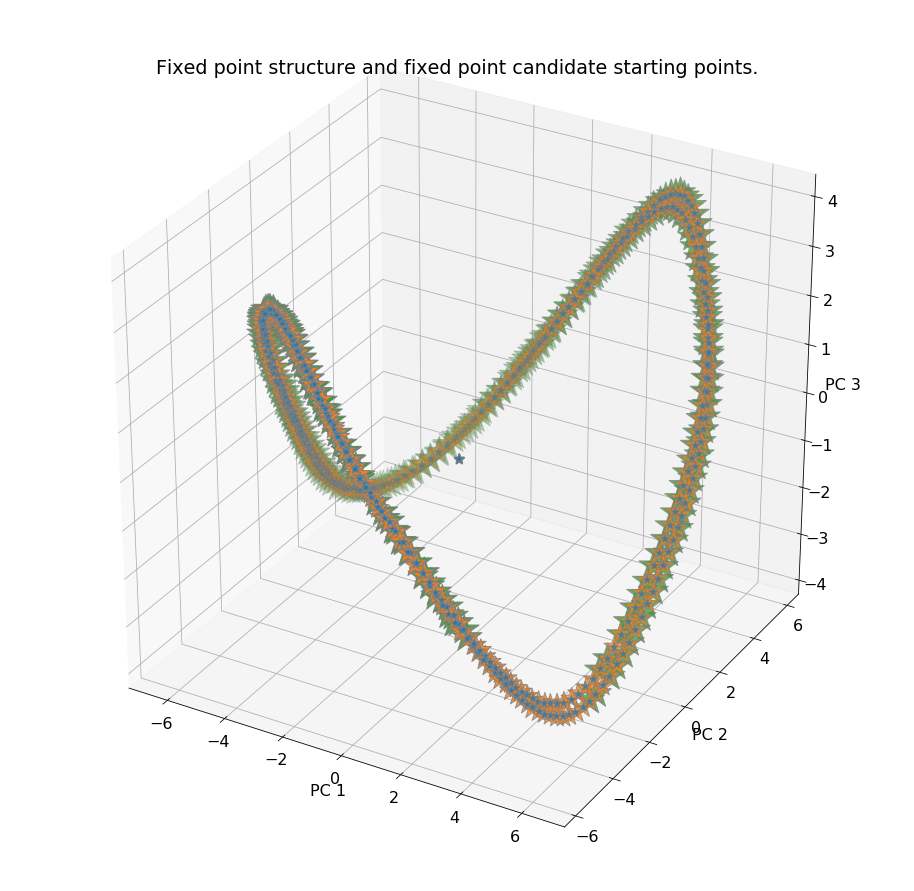

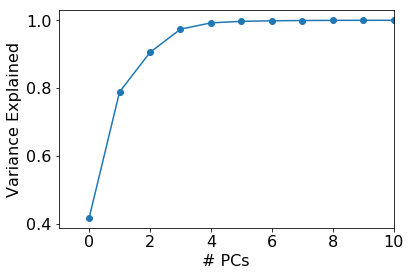

In [136]:
n=N
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
fig = plt.figure(figsize=(16,16));
ax = fig.add_subplot(111, projection='3d');

pca = PCA(n_components=30).fit(fp_candidates)

max_fps_to_plot = 1000
sizes = [100, 500, 1000]
for tol, size in zip(fp_tols[0:3], sizes):
    hiddens = all_fps[tol]['candidates']

    h_pca = pca.transform(hiddens)

    emax = h_pca.shape[0] if h_pca.shape[0] < max_fps_to_plot else max_fps_to_plot

    alpha = 0.01
    ax.scatter(h_pca[0:emax,0], h_pca[0:emax,1], h_pca[0:emax,2], color=[0, 0, 0, 0.1], s=10)

    hstars = np.reshape(all_fps[tol]['fps'], (-1, n))
    hstar_pca = pca.transform(hstars)
    
    marker_style = dict(marker='*', s=size, edgecolor='gray')
    
    ax.scatter(hstar_pca[0:emax,0], hstar_pca[0:emax,1], hstar_pca[0:emax,2], 
                'k', **marker_style);#c=color[0:emax], **marker_style);

    for eidx in range(emax):
        ax.plot3D([h_pca[eidx,0], hstar_pca[eidx,0]], 
                  [h_pca[eidx,1], hstar_pca[eidx,1]],
                  [h_pca[eidx,2], hstar_pca[eidx,2]], c=[0, 0, 1, alpha])    
        
plt.title('Fixed point structure and fixed point candidate starting points.');
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.show()

plt.plot(onp.cumsum(pca.explained_variance_ratio_),'-o')
plt.xlim((-1,10))
plt.xlabel('# PCs')
plt.ylabel('Variance Explained')
plt.show()

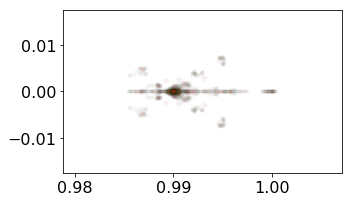

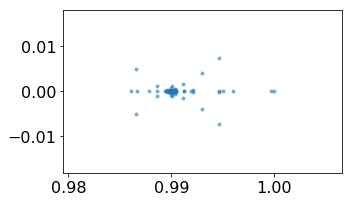

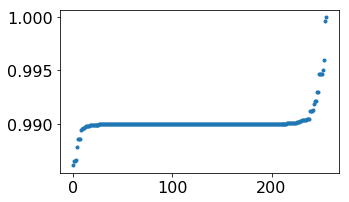

In [137]:
plt.figure(figsize=(5, 3))

for decomp in eig_decomps:
    plt.scatter(decomp['evals'].real, decomp['evals'].imag, marker = '.', alpha = .01)
plt.show()

plt.figure(figsize=(5, 3))
plt.scatter(decomp['evals'].real, decomp['evals'].imag, marker = '.', alpha = .5)
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(onp.sort(decomp['evals'].real),'.')
plt.show()

In [177]:
# Everything is in the nullspace of the readout still so these vals will be close to zero
ldots = []
rdots = []
rdotla = []
del_x = trial.x[T,0,:] - trial.x[T-1,0,:] 

nfps = len(sorted_fps)
for jidx in range(nfps):
    fp = sorted_fps[jidx, :]
    rnn_fun_x = lambda x : rnn_vanilla(params, fp, onp.squeeze(x.T))
    dfdx = jacrev(rnn_fun_x)
    r0 = onp.real(eig_decomps[jidx]['R'][:,0])                          
    rdots.append(onp.dot(r0.T, params[2]))
    l0 = onp.real(eig_decomps[jidx]['L'][:,0])
    ldots.append(onp.dot(l0.T, dfdx(del_x)[:,:3]))

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(sorted_fp_readouts, onp.abs(rdots)[:,1], c = 'k')
plt.title('Rights dotted with readout')
plt.subplot(122)
plt.scatter(sorted_fp_readouts, onp.abs(ldots)[:,1], c = 'k')
plt.title('Lefts dotted with effective input')
# plt.ylim([0, 3]);

Exception: Tracer can't be used with raw numpy functions. You might have
  import numpy as np
instead of
  import jax.numpy as np

In [156]:
def plot_FP(X, D, qvals):
    """Plot activity is some 2D space.

        Args:
            X: Fixed points in #Fps x Neurons
            D: Neurons x 2 plotting dims
    
        """
    log_qvals = np.log10(qvals)

    qmap=plt.get_cmap('gray')
    S = np.shape(X)[0]
    
    for s in range(S):
        c = 'k'
        X_trial = np.dot(X[s,:],D.T)
        plt.plot(X_trial[0],X_trial[1],'*',c = c)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/networks_for_david/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/networks_for_david/l2w0001/0/model.ckpt


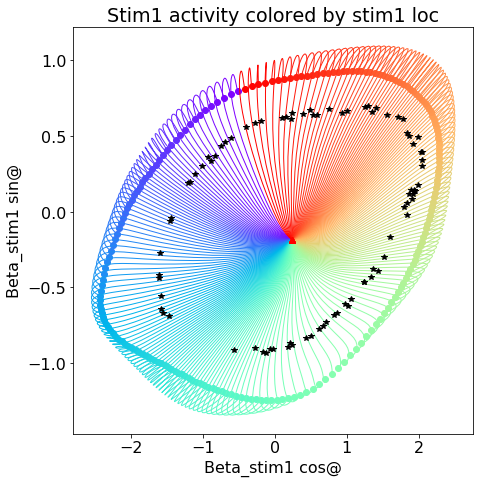

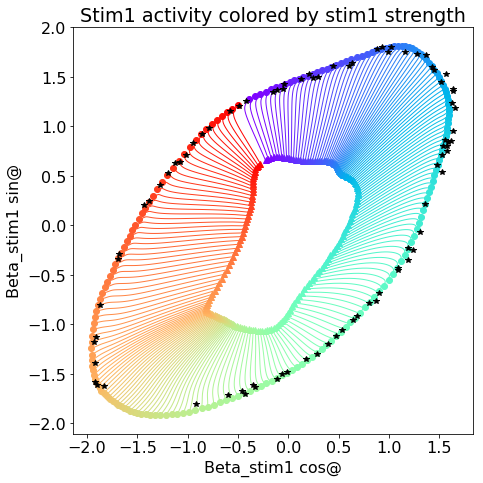

In [163]:
## do regression with random trials
e1 = 'stim1'
e2 = 'delay1'

T1_use = trial.epochs[e1][1]
T2_use = trial.epochs[e2][1]

inds_use1 = trial.stim_strength[:,0]>.99
stim1 = trial.stim_locs[inds_use1,0:1]
X = h_tf[T1_use,inds_use1,:].T
y1 = np.sin(stim1)
y2 = np.cos(stim1)
y = onp.concatenate((y1,y2),axis=1)

X_zscore = stats.zscore(X, axis=1)
X_zscore_nonan = X_zscore
X_zscore_nonan[np.isnan(X_zscore)] = 0
r = X_zscore_nonan

lm = linear_model.LinearRegression()
model = lm.fit(y,r.T)
Beta = model.coef_
Beta_e1,_ = LA.qr(Beta)

inds_use2 = trial.stim_strength[:,0]>.99
stim2 = trial.stim_locs[inds_use2,0:1]
X = h_tf[T2_use,inds_use2,:].T
y1 = np.sin(stim2)
y2 = np.cos(stim2)
y = onp.concatenate((y1,y2),axis=1)

X_zscore = stats.zscore(X, axis=1)
X_zscore_nonan = X_zscore
X_zscore_nonan[np.isnan(X_zscore)] = 0
r = X_zscore_nonan

lm = linear_model.LinearRegression()
model = lm.fit(y,r.T)
Beta = model.coef_
Beta_e2,_ = LA.qr(Beta)

## plot w test set of trials
model = Model(model_dir_all)
with tf.Session() as sess:
    model.restore()
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='test', noise_on=False, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

fig = plt.figure(figsize=(7, 7),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})

inds_use = range(0,np.shape(h_tf)[1],2)#onp.argsort(trial.stim_locs[:,0])[0:1000:2]#range(0,1000,50)#
D = np.concatenate((np.expand_dims(Beta_e1[:,0],axis=1),np.expand_dims(Beta_e1[:,1],axis=1)),axis = 1)
X = onp.transpose(h_tf[trial.epochs[e1][0]-1:trial.epochs[e1][1],inds_use,:],(1, 0, 2))
plot_N(X,D.T,inds_use)

plot_FP(sorted_fps, D.T, fp_losses)

plt.xlabel('Beta_' + e1 + ' cos@')
plt.ylabel('Beta_' + e1 + ' sin@')
plt.title('Stim1 activity colored by stim1 loc')  
plt.show()

fig = plt.figure(figsize=(7, 7),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})

inds_use = range(0,np.shape(h_tf)[1],2)#onp.argsort(trial.stim_strength[:,0])[0:1000:2]#range(0,1000,50)#
D = np.concatenate((np.expand_dims(Beta_e2[:,0],axis=1),np.expand_dims(Beta_e2[:,1],axis=1)),axis = 1)
X = onp.transpose(h_tf[trial.epochs[e2][0]-1:trial.epochs[e2][1],inds_use[-1:0:-1],:],(1, 0, 2))
plot_N(X,D.T,inds_use)

plot_FP(sorted_fps, D.T, fp_losses)

plt.xlabel('Beta_' + e1 + ' cos@')
plt.ylabel('Beta_' + e1 + ' sin@')
plt.title('Stim1 activity colored by stim1 strength')  
plt.show()
